<a href="https://colab.research.google.com/github/riponazad/PyTorch_Learning/blob/main/LeNet_5_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(16*4*4,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        #x = self.sm(x)
        return x

In [ ]:
# creating model,and defining optimizer and loss
model = LeNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

We're using => cuda:0
LeNet(
  (convlayer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (sm): Softmax(dim=1)
)


In [ ]:
def output_label(label):
    output_mapping = {
                 0: "Zero",
                 1: "One",
                 2: "Two",
                 3: "Three",
                 4: "Four", 
                 5: "Five", 
                 6: "Six",
                 7: "Seven",
                 8: "Eight",
                 9: "Nine"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Five


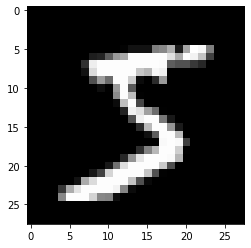

In [ ]:
image, label = next(iter(trainset))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

In [ ]:
def Accuracy(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
print("Begin training.")
for e in tqdm(range(5)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.49544 | Train Acc: 84.38593



Epoch 01: | Train Loss: 0.08781 | Train Acc: 97.19296



Epoch 02: | Train Loss: 0.06393 | Train Acc: 97.83156



Epoch 03: | Train Loss: 0.04985 | Train Acc: 98.34435



Epoch 04: | Train Loss: 0.04196 | Train Acc: 98.52878



In [ ]:
#TESTING
y_pred_list = []
y_true_list = []
correct_results_sum = 0
num_samples = 0
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _h, y_pred_tag = torch.max(y_test_pred, dim = 1)
        #print(_h, y_pred_tag)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        correct_results_sum += (y_pred_tag == y_batch).sum()
        num_samples += len(y_batch)
acc = correct_results_sum.float()/num_samples
acc = torch.round(acc * 100)
print(f'Accuracy: {acc}')


Accuracy: 99.0


In [ ]:
y_pred = []
y_true = []
for i in range(len(y_true_list)):
    for j in range(len(y_true_list[i])):
        y_pred.append(y_pred_list[i][j])
        y_true.append(y_true_list[i][j])
len(y_true), len(y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.96      1.00      0.98      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.96      0.98       892
           6       1.00      0.97      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

